#### **Load Dataset**

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Final.csv", encoding="latin-1")  # Use 'latin-1' encoding if UTF-8 causes issues

# Display the first few rows
print(df.head())

from sklearn.model_selection import train_test_split
# Split the dataset into train (80%) and test (20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# Assign the train and test sets back to df
df = {'train': train_df, 'test': test_df}
# Save separate CSV files
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

   Delivery_person_Age  Delivery_person_Ratings  Weather_conditions  \
0                   36                      4.2                   4   
1                   21                      4.7                   6   
2                   23                      4.7                   5   
3                   34                      4.3                   5   
4                   24                      4.7                   4   

   Road_traffic_density  multiple_deliveries  Festival  \
0                     4                    3         0   
1                     3                    1         0   
2                     2                    1         0   
3                     1                    0         0   
4                     4                    1         0   

   Vehicle_performance_Impact  rush_day  pickup_time  Travel_Distance  \
0                          12         5         15.0             11.6   
1                           8         6         10.0             11.1   
2    

#### **Dataset split (train, test) Intialize**

In [2]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data from separate files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Separate features and target (adjust column names as needed)
X_train = train_df.drop('Time_taken', axis=1)  # Replace 'target' with your actual target column name
y_train = train_df['Time_taken']
X_test = test_df.drop('Time_taken', axis=1)
y_test = test_df['Time_taken']

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

#### **Parameter Optimized Train Model (MAE, MSE, R^2)**

In [21]:
from openpyxl import load_workbook

# Model parameters with your specified values
params = {
    'objective': 'regression',
    'metric': ['mae', 'mse'],
    'boosting_type': 'gbdt',
    'num_leaves': 255,
    'learning_rate': 0.05,
    'max_depth': 0,
    'min_data_in_leaf': 12,
    'random_state': 42,
    'feature_fraction': 0.5,
    'verbosity': -1,
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=21000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(100)
    ]
)

# Generate predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    return {
        'Dataset': set_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

metrics = [
    calculate_metrics(y_train, train_pred, 'Training'),
    calculate_metrics(y_test, test_pred, 'Test')
]

# Display metrics
metrics_df = pd.DataFrame(metrics)
print("\nPerformance Metrics:")
print(metrics_df.to_markdown(index=False))

Training until validation scores don't improve for 100 rounds
[100]	train's l1: 2.67288	train's l2: 12.8251	test's l1: 3.0201	test's l2: 16.7119
[200]	train's l1: 2.32185	train's l2: 9.70139	test's l1: 2.89971	test's l2: 15.5056
[300]	train's l1: 2.13063	train's l2: 8.23826	test's l1: 2.88634	test's l2: 15.4055
[400]	train's l1: 1.99476	train's l2: 7.35196	test's l1: 2.87996	test's l2: 15.3989
Early stopping, best iteration is:
[388]	train's l1: 2.00992	train's l2: 7.45211	test's l1: 2.87902	test's l2: 15.3875

Performance Metrics:
| Dataset   |     MAE |      MSE |    RMSE |       R2 |
|:----------|--------:|---------:|--------:|---------:|
| Training  | 2.00992 |  7.45211 | 2.72986 | 0.914865 |
| Test      | 2.87902 | 15.3875  | 3.92269 | 0.823925 |


In [5]:
# Append parameters and performance metrics to an Excel file

# Create a DataFrame for parameters
params_df = pd.DataFrame([params])

# Add a column to indicate the dataset type
params_df['Dataset'] = 'Parameters'

# Define the Excel file name
excel_file = 'Model_performance.xlsx'

# Combine parameters and metrics into one DataFrame
combined_df = pd.concat([params_df, metrics_df], ignore_index=True)

try:
    # Try to load the existing workbook
    book = load_workbook(excel_file)
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='new') as writer:
        combined_df.to_excel(writer, index=False, sheet_name=f'Run_{len(book.sheetnames) + 1}')
except FileNotFoundError:
    # If the file does not exist, create a new one
    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        combined_df.to_excel(writer, index=False, sheet_name='Run_1')

print(f"\nParameters and performance metrics saved to {excel_file}")


Parameters and performance metrics saved to Model_performance.xlsx


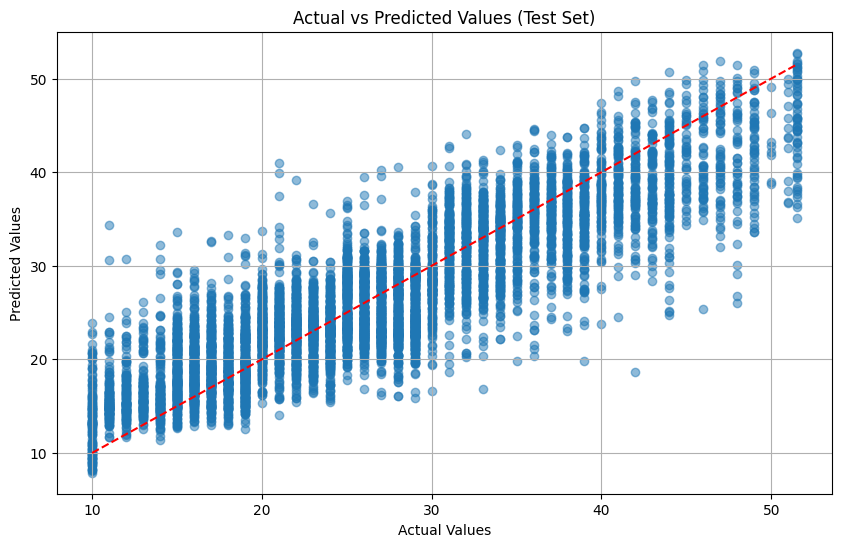

In [5]:
# Plot actual vs predicted for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Test Set)')
plt.grid()
plt.show()

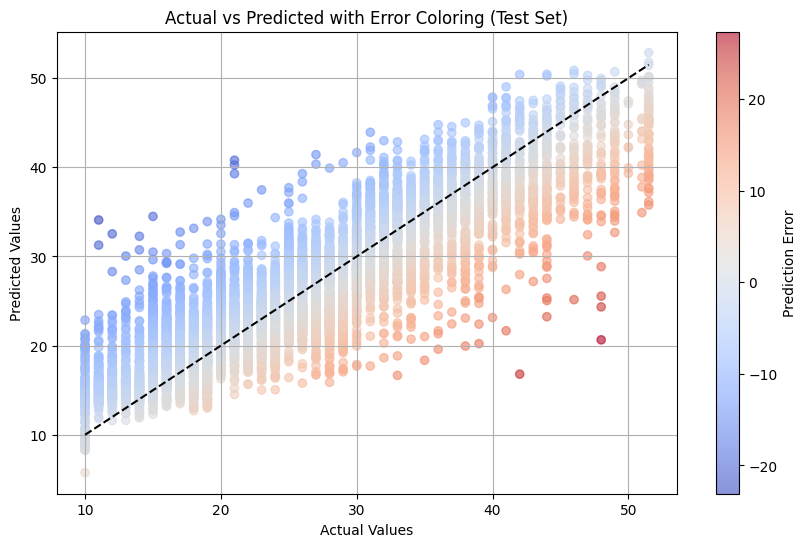

In [7]:
# Plot with color indicating error magnitude
errors = y_test - test_pred
plt.figure(figsize=(10, 6))
scatter = plt.scatter(y_test, test_pred, c=errors, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Prediction Error')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted with Error Coloring (Test Set)')
plt.grid()
plt.show()

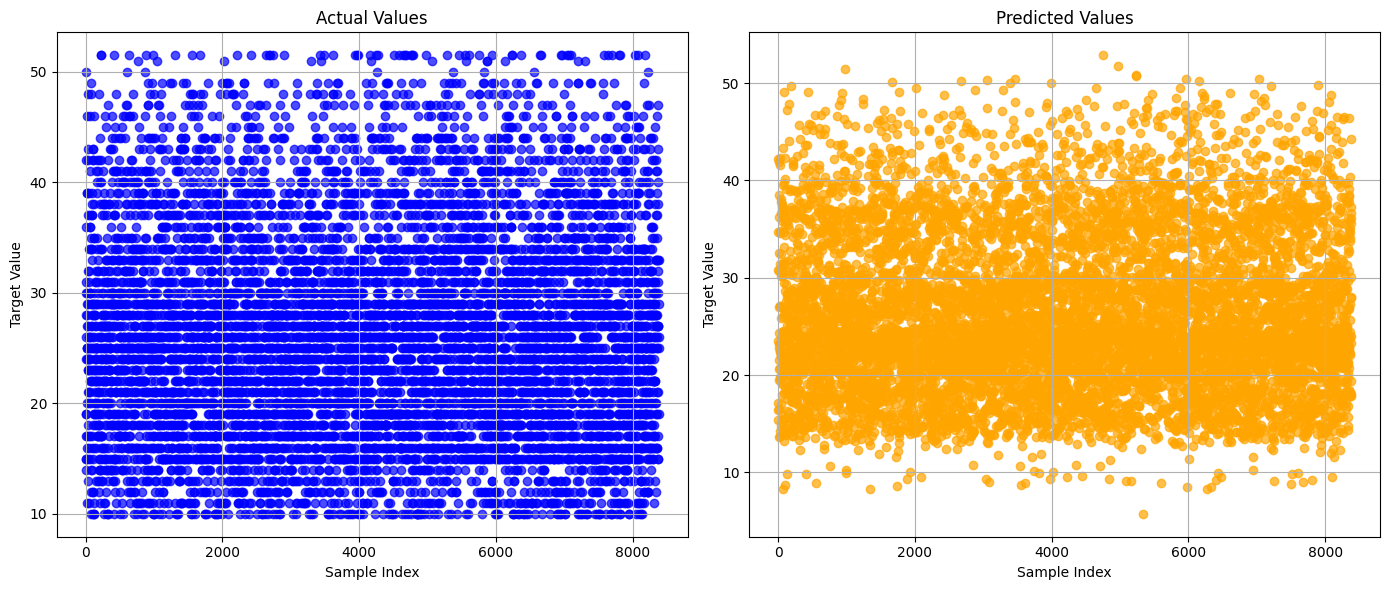

In [8]:
# Side-by-side comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.7)
plt.title('Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(range(len(test_pred)), test_pred, color='orange', alpha=0.7)
plt.title('Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.grid()

plt.tight_layout()
plt.show()

In [9]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_pred,
    'Difference': y_test - test_pred,  # Optional: include error/difference
    'Absolute_Error': np.abs(y_test - test_pred)  # Optional: include absolute error
})

# Save to Excel file
results_df.to_excel('actual_vs_predicted.xlsx', index=False, sheet_name='Results')

print("Prediction.xlsx'")

Prediction.xlsx'
